## Importing Libraries and packages

In [27]:
import wntr             # For EPANET file reading
import numpy as np      
import pandas as pd
import re
import math
import pathlib 
import pyswmm
from swmm.toolkit.shared_enum import LinkAttribute, NodeAttribute
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt


font = {'family' : 'Times',
        'weight' : 'bold',
        'size'   : 12}
mpl.rc('font', **font)
mpl.rcParams['figure.dpi'] = 600
mpl.rcParams["mathtext.fontset"]="dejavuserif"

### Specifying paths for EPANET.inp File to be Converted and preprocessing the input
**Warning:** *Paths in this script (and the rest of this repo) are absolute unless running the network files provided within the repo*  
Input filename (with extensions) as string.  
For running the .inp files in this repository, you can use this relative path `"../Networks/X/"` where X is the network name  
Will work with both Windows and POSIX paths

In [10]:
 # Replace with appropriate path and filename
directory=pathlib.Path("../Networks/Single Node Test")
filename=pathlib.Path("Single SWMMIN node.inp")
name_only=str(filename.stem)
print("Selected File: ",name_only)
path=directory/filename

Selected File:  Single SWMMIN node


In [11]:
sim=pyswmm.Simulation (str(path), outputfile=str(path.with_suffix(".out")))

In [12]:
nodes=pyswmm.nodes.Nodes(sim)
tankids=[]
for node in nodes:
    if re.search('StorageforNode',node.nodeid):
        tankids.append(node.nodeid)
demand_node_ids=[x[14:] for x in tankids]
Withdraw_ids = ["OutletforNode" + x for x in demand_node_ids]
Consume_ids = ["DemandOutletforNode" + x for x in demand_node_ids]

In [13]:
stp=0       #steps counter
every=1000  #Interval of printing current time

# runs the simulation step by step
with sim as sim:
    system_routing = pyswmm.SystemStats(sim)
    for step in sim:
        if stp%every==0:
            print('Current Simulation Time is >> ',sim.current_time,", ",round(sim.percent_complete*100,1),"% Complete")
        stp+=1
        pass
    sim._model.swmm_end()
    print("Continuity Error: ",sim.flow_routing_error,"%\n")

Current Simulation Time is >>  2024-09-23 00:00:01 ,  0.0 % Complete
Current Simulation Time is >>  2024-09-23 00:16:41 ,  1.2 % Complete
Current Simulation Time is >>  2024-09-23 00:33:21 ,  2.3 % Complete
Current Simulation Time is >>  2024-09-23 00:50:01 ,  3.5 % Complete
Current Simulation Time is >>  2024-09-23 01:06:41 ,  4.6 % Complete
Current Simulation Time is >>  2024-09-23 01:23:21 ,  5.8 % Complete
Current Simulation Time is >>  2024-09-23 01:40:01 ,  6.9 % Complete
Current Simulation Time is >>  2024-09-23 01:56:41 ,  8.1 % Complete
Current Simulation Time is >>  2024-09-23 02:13:21 ,  9.3 % Complete
Current Simulation Time is >>  2024-09-23 02:30:01 ,  10.4 % Complete
Current Simulation Time is >>  2024-09-23 02:46:41 ,  11.6 % Complete
Current Simulation Time is >>  2024-09-23 03:03:21 ,  12.7 % Complete
Current Simulation Time is >>  2024-09-23 03:20:01 ,  13.9 % Complete
Current Simulation Time is >>  2024-09-23 03:36:41 ,  15.0 % Complete
Current Simulation Time is >>

In [14]:
swtch=True                   # switch variable for upcoming condition

# Reads the output file created above
with pyswmm.Output(str(path.with_suffix(".out"))) as out:
    # loops through each node in output file
    for link in out.links:

        # One time only. Gets the timesteps (the keys in the output series dictionary) and stores them to be used as index
        if swtch:
        # node_series produces a dictionary with the keys corresponding to timestamps and values contain the value of the selected variable (FLOW_RATE) at each timestamp
            index = pd.Series(out.link_series(link,LinkAttribute.FLOW_RATE).keys())
        
        # If node id is in the prepared list of demand nodes (tanks)
        if link in Withdraw_ids:
            Q_tank=pd.Series(out.link_series(link,LinkAttribute.FLOW_RATE).values())  
        elif link in Consume_ids:
            Q_cons = pd.Series(out.link_series(link,LinkAttribute.FLOW_RATE).values())
            #IGNORE THE WARNING (THE SUGGESTED concat is slower and is more difficult to achieve the needed formatting)
    
    for node in out.nodes:
        if node in demand_node_ids:
            H=pd.Series(out.node_series(node,NodeAttribute.INVERT_DEPTH).values())
        if node in tankids:
            V=pd.Series(out.node_series(node,NodeAttribute.PONDED_VOLUME).values())
            h = pd.Series(out.node_series(node,NodeAttribute.INVERT_DEPTH).values())

In [18]:
data_dict = {
    'Time': index,
    'Q_tank': Q_tank,
    'Q_cons': Q_cons,
    'H': H,
    'V': V,
    'h': h
}
data = pd.DataFrame(data_dict)

Q_des, H_des = 10, 10
data["Q_w"] = Q_des * (data["H"] / H_des)**(1/2)

# Ensure the Time column is in datetime format
data['Time'] = pd.to_datetime(data['Time'])

# Convert Time to decimal hours
data['Time'] = data['Time'].dt.hour + data['Time'].dt.minute / 60 + data['Time'].dt.second / 3600
data=data[:-1]
data.head()

,Time,Q_tank,Q_cons,H,V,h,Q_w
0,0.000278,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000556,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000833,0.0,0.0,0.0,0.0,0.0,0.0
3,0.001111,0.0,0.0,0.0,0.0,0.0,0.0
4,0.001389,0.0,0.0,0.0,0.0,0.0,0.0


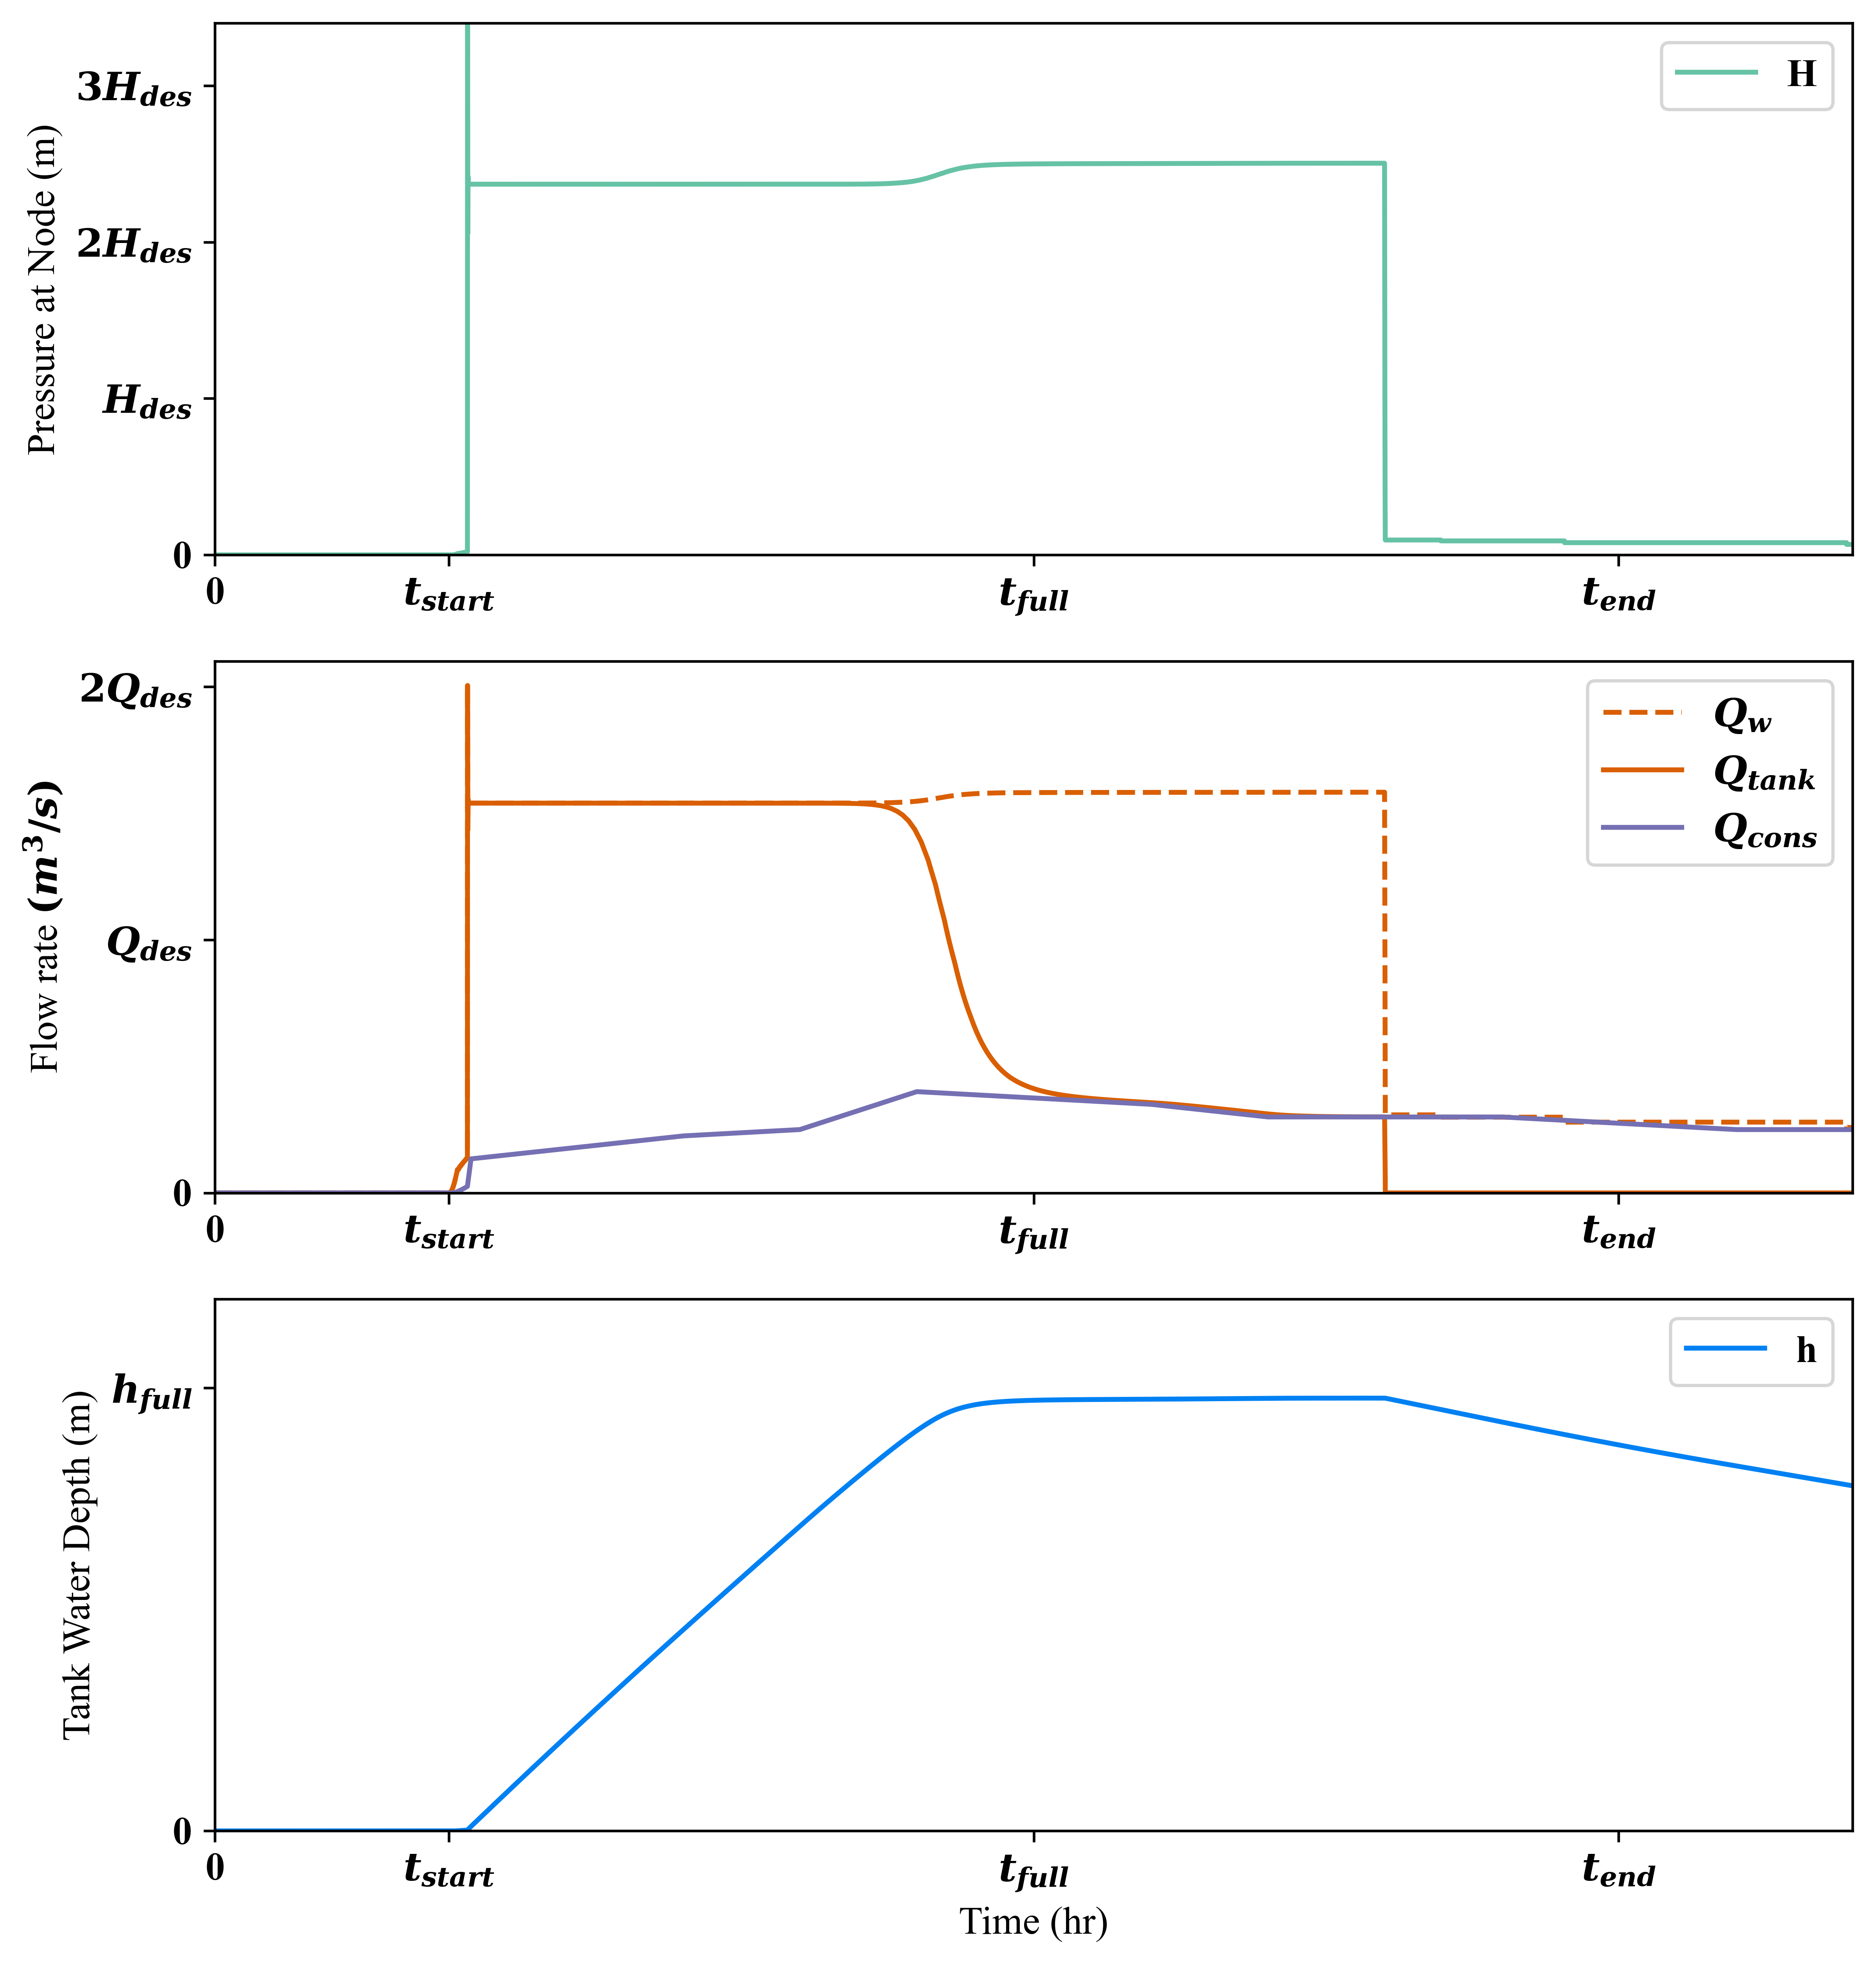

In [32]:
fig, ax = plt.subplots(3,1, sharex=False)
fig.set_figheight(10)
fig.set_figwidth(9)
# Set the font to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

fig.set_facecolor('none')  # or fig.set_facecolor('none')

x_max = 14

line1, = ax[0].plot(data["Time"],data["H"], label ="H", c = "#66c2a5")
ax[0].set_ylim(0,34)
ax[0].set_xlim(0,x_max)

ax[0].set_yticks([0,10,20,30])
ax[0].set_yticklabels(['0',r'$H_{des}$',r'$2H_{des}$',r'$3H_{des}$'])
ax[0].set_ylabel("Pressure at Node (m)")
ax[0].set_xticks([0,2,7,12])
ax[0].set_xticklabels(['0',r'$t_{start}$',r'$t_{full}$',r'$t_{end}$'])


ax[1].plot(data["Time"],data["Q_w"], label = r"$Q_w$", c='#d95f02', ls = '--')
ax[1].plot(data["Time"],data["Q_tank"], label = r"$Q_{tank}$", c='#d95f02')
ax[1].plot(data["Time"],data["Q_cons"], label = r"$Q_{cons}$", c ="#7570b3")

ax[1].set_xlim(0,x_max)
ax[1].set_ylim(0,21)
ax[1].set_xticks([0,2,7,12])
ax[1].set_xticklabels(['0',r'$t_{start}$',r'$t_{full}$',r'$t_{end}$'])
ax[1].set_yticks([0,10,20])
ax[1].set_yticklabels(['0',r'$Q_{des}$',r'$2Q_{des}$'])
ax[1].set_ylabel('Flow rate $(m^3/s)$')


line2, =ax[2].plot(data["Time"],data["h"], label = "h", c = "#0081F3")

ax[2].set_ylim(0,1.2)
ax[2].set_xlim(0,x_max)

ax[2].set_yticks([0,1])
ax[2].set_xlabel("Time (hr)")
ax[2].set_yticklabels(['0',r'$h_{full}$'])
ax[2].set_ylabel("Tank Water Depth (m)")
ax[2].set_xticks([0,2,7,12])
ax[2].set_xticklabels(['0',r'$t_{start}$',r'$t_{full}$',r'$t_{end}$'])



lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax[0].legend()
ax[1].legend()
# ax[2].legend(lines,labels, loc = 'lower right')
ax[2].legend()

In [31]:
import matplotlib.pyplot as plt

# Set the font to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

fig.set_facecolor('none')  # or fig.set_facecolor('none')

x_max = 14

line1, = ax[0].plot(data["Time"], data["H"], label="H", c="#66c2a5")
ax[0].set_ylim(0, 34)
ax[0].set_xlim(0, x_max)

ax[0].set_yticks([0, 10, 20, 30])
ax[0].set_yticklabels(['0', r'$H_{des}$', r'$2H_{des}$', r'$3H_{des}$'])
ax[0].set_ylabel("Pressure at Node (m)")
ax[0].set_xticks([0, 2, 7, 12])
ax[0].set_xticklabels(['0', r'$t_{start}$', r'$t_{full}$', r'$t_{end}$'])

ax[1].plot(data["Time"], data["Q_w"], label=r"$Q_w$", c='#d95f02', ls='--')
ax[1].plot(data["Time"], data["Q_tank"], label=r"$Q_{tank}$", c='#d95f02')
ax[1].plot(data["Time"], data["Q_cons"], label=r"$Q_{cons}$", c="#7570b3")

ax[1].set_xlim(0, x_max)
ax[1].set_ylim(0, 21)
ax[1].set_xticks([0, 2, 7, 12])
ax[1].set_xticklabels(['0', r'$t_{start}$', r'$t_{full}$', r'$t_{end}$'])
ax[1].set_yticks([0, 10, 20])
ax[1].set_yticklabels(['0', r'$Q_{des}$', r'$2Q_{des}$'])
ax[1].set_ylabel('Flow rate $(m^3/s)$')

line2, = ax[2].plot(data["Time"], data["h"], label="h", c="#0081F3")

ax[2].set_ylim(0, 1.2)
ax[2].set_xlim(0, x_max)

ax[2].set_yticks([0, 1])

In [25]:
mpl.font_manager._rebuild()

AttributeError: module 'matplotlib.font_manager' has no attribute '_rebuild'